# Create Infrastructure Barcharts

This notebook provides the code to create barcharts of (1) new power plant capacity through 2050 by state and techonlogy and (2) land usage (km-squared) of new power plants through 2050 by state and technology

### Imports

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
import os

### Settings

In [2]:
color_map_dict={
    'Natural Gas':'#bdb59d',
    'Coal': '#75736d',
    'Solar PV': '#F7B615',
    'Solar CSP': '#f1781b',
    'Wind': '#95C060', 
    'Nuclear': '#6D547C', 
    'Offshore Wind':'#2B7F9E', 
    'Biomass': '#713275',
    'Geothermal': '#BB3B1C', 
    'Oil': '#BB3B1C',
    'Hydro': '#14345e'}

### Data Paths

In [3]:
# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'input_data')

# output figure dir
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'figures', 'infrastructure_barcharts')

# infrastructure siting output csv
infrastucture_path = os.path.join(data_dir, 'infrastructure_data_csv', 'infrastructure_data_2050.csv')

# CONUS shapefile
conus_shp_path = os.path.join(data_dir, 'conus_shp', 'cb_2018_us_state_5m', 'cb_2018_us_state_5m.shp')

### Functions

In [4]:
def plot_infrastructure_bar(df, scenario, title, year, output_file_name):

    df_plot = df[df.scenario==scenario].copy()
    df_plot['unit_size_mw'] = df_plot['unit_size_mw'] / 1000
    df_plot = df_plot.rename(columns={'unit_size_mw': 'GW', 'tech_name_simple':'Technology'})

    # collect new infrastructure
    new_df = df_plot[df_plot.cerf_sited == 1].copy()
    new_df['Year'] = new_df.sited_year
    new_df = new_df.groupby(['Technology', 'Year'], as_index=False).sum()

    # collect new infrastructure
    ret_df = df_plot[df_plot.cerf_sited == 0].copy()
    ret_df['GW'] = ret_df['GW'] * -1
    ret_df = ret_df[ret_df.retirement_year <= year]
    ret_df['Year'] = ret_df.retirement_year
    ret_df = ret_df.groupby(['Technology', 'Year'], as_index=False).sum()

    fig_df = pd.concat([new_df, ret_df])

    fig = px.bar(fig_df, x="Year", y='GW', color="Technology", title=title, color_discrete_map=color_map_dict, width=900, height=500)
    fig.update_yaxes(range=[-75, 150])    
    fig.update_layout(uniformtext_minsize=18, uniformtext_mode='hide',  plot_bgcolor = 'white', paper_bgcolor ='white')
    fig.update_yaxes(title="GW", showgrid = True,  gridcolor = '#bdbdbd')
    fig.add_hline(y=0,line_width=3, line_dash="dash", line_color="black")

    fig.update_xaxes(tickmode = 'array',
                     tickvals = list(range(2025, year+1, 5)),
                     ticktext= ['2025', '2030', '2035', '2040', '2045', '2050'])
    fig.update_traces(width=3)

    fig.write_image(os.path.join(fig_dir , output_file_name))
    
    return fig.show()


def plot_state_bar_capacity(df, scenario, year, output_file_name, title):

    df_bar = df[df.scenario==scenario].copy()
    
    df_bar = df_bar[df_bar.cerf_sited==1]
    
    df_bar = df_bar[['region_name', 'tech_name_simple', 'unit_size_mw']].groupby(['region_name', 'tech_name_simple'], as_index=False).sum()
    
    df_bar = df_bar.rename(columns={'tech_name_simple':'Technology', 'region_name': 'State'})
    
    df_bar['unit_size_mw'] = df_bar['unit_size_mw']/1000
    
    fig = px.bar(df_bar, x="State", y='unit_size_mw', color="Technology", title=title,
                color_discrete_map=color_map_dict,
                width=1000, height=500)
    fig.update_layout(uniformtext_minsize=18, uniformtext_mode='hide', yaxis_range=[0,160], plot_bgcolor = 'white', paper_bgcolor ='white')
    fig.update_yaxes(title="GW", showgrid = True,  gridcolor = '#bdbdbd')

    fig.update_xaxes(categoryorder='category ascending')

    fig.write_image(os.path.join(fig_dir , output_file_name))
    
    return fig.show()


def plot_state_bar_land(df, scenario, year, output_file_name, title):

    df_bar = df[df.scenario==scenario].copy()
    
    df_bar = df_bar[df_bar.cerf_sited==1]
    
    df_bar = df_bar.groupby(['region_name', 'tech_name_simple'], as_index=False).count()
    
    df_bar = df_bar.rename(columns={'tech_name_simple':'Technology', 'region_name': 'State'})
    
    fig = px.bar(df_bar, x="State", y='xcoord', color="Technology", title=title,
                color_discrete_map=color_map_dict,
                width=1000, height=500)
    fig.update_layout(uniformtext_minsize=18, uniformtext_mode='hide', yaxis_range=[0,4500], plot_bgcolor = 'white', paper_bgcolor ='white')
    fig.update_yaxes(title="square km", showgrid = True,  gridcolor = '#bdbdbd')
    
    fig.update_xaxes(categoryorder='category ascending')

    fig.write_image(os.path.join(fig_dir , output_file_name))
    
    return fig.show()

### Collect Data

In [26]:
# read in infrastructure data
df = pd.read_csv(infrastucture_path)

In [27]:
year = 2050

# reduce to year of interest
df = df[df.sited_year <=year]

## Create Figures

#### Reference map

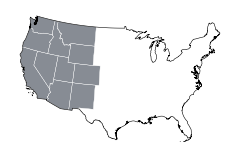

In [83]:
conus = gpd.read_file(conus_shp_path).to_crs('ESRI:102003')
conus#.plot()

conus = conus[~conus.STUSPS.isin(['AS', 'VI', 'HI', 'AK', 'PR', 'MP', 'GU'])]
wecc_states = ['CA', 'OR', 'WA', 'MT', 'ID', 'WY', 'UT', 'NV', 'AZ', 'NM', 'CO']
conus_boundary = conus.dissolve()

figsize = (2.5, 2)
fig, ax = plt.subplots(figsize=figsize)
ax.set_axis_off();
conus.plot(ax=ax, color='white')
conus[conus.STUSPS.isin(wecc_states)].plot(ax=ax, color='#878c94')
conus.boundary.plot(ax=ax, color='white', lw=.2)
conus_boundary.boundary.plot(ax=ax, color='black', lw=.4)
plt.tight_layout()
output_file_name = 'reference_map.png'
plt.savefig(os.path.join(fig_dir , output_file_name), dpi=300)
plt.show()

### Figure 1 - Comparison of Land Usage and Capacity Additions by State and Scenario

In [91]:
df_bar = df.copy()
df_bar = df_bar[df_bar.cerf_sited==1]

df_cap = df_bar.copy()
df_cap = df_cap[['scenario', 'region_name', 'tech_name_simple', 'unit_size_mw']].groupby(['scenario','region_name', 
                                                                                          'tech_name_simple'], as_index=False).sum()
df_cap = df_cap.rename(columns={'tech_name_simple':'Technology', 'region_name': 'State'})
df_cap['GW'] = df_cap['unit_size_mw']/1000

df_cap = pd.melt(df_cap, id_vars=['Technology', 'State', 'scenario'], value_vars=['GW'],
        var_name='var', value_name='value')

df_km = df_bar.copy()
df_km = df_km[['scenario', 'region_name', 'tech_name_simple', 'unit_size_mw']].groupby(['scenario','region_name', 
                                                                                        'tech_name_simple'], as_index=False).count()
df_km = df_km.rename(columns={'tech_name_simple':'Technology', 'region_name': 'State', 'unit_size_mw':'km-squared'})
df_km = pd.melt(df_km, id_vars=['Technology', 'State', 'scenario'], value_vars=['km-squared'],
        var_name='var', value_name='value')


df_plot = pd.concat([df_cap, df_km])

df_plot['scenario'].replace('business_as_usual_ira_ccs_climate', 'Business-as-usual', inplace=True)
df_plot['scenario'].replace('net_zero_ira_ccs_climate', 'Clean Grid', inplace=True)
df_plot['State'] = df_plot['State'].str.title()
df_plot['State'] = df_plot['State'].replace("New_Mexico", "New Mexico")

In [121]:


fig = px.bar(df_plot, x="State", y='value', color="Technology", title='',
            color_discrete_map=color_map_dict,
            width=900, height=700, 
             facet_col="scenario", facet_row='var',
            facet_col_spacing=0.1,
            facet_row_spacing=0.1)

fig.update_layout(uniformtext_minsize=18, uniformtext_mode='hide', plot_bgcolor = 'white', paper_bgcolor ='white')
fig.update_yaxes(showgrid = True,  gridcolor = '#bdbdbd',showticklabels=True, visible=True)

# makes the y-axes match in each row
fig.layout.yaxis.matches = 'y'
fig.layout.yaxis2.matches = 'y'
fig.layout.yaxis3.matches = 'y4'
fig.layout.yaxis4.matches = 'y4'

# Updates y-axis labels
fig.update_xaxes(title_text="", row=1, col=1)
fig.update_yaxes(title_text="Capacity Additions (GW)", row=2, col=1)
fig.update_xaxes(title_text="", row=1, col=2)
fig.update_yaxes(title_text="Land Usage (km<sup>2</sup>)", row=1, col=1)

# suppresses row facet labels
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("GW", "")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("km-squared", "")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Business-as-usual", "")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Clean Grid", "")))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.update_layout(
    font=dict(
        family="Arial",
        size=12,
        color="black"
    )
)
fig.add_annotation(
    text="Business-as-usual",
    x=0.14, y=1.10,
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=15),
)

fig.add_annotation(
    text="Net Zero",
    x=0.8, y=1.10,
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=15),
)

fig.add_annotation(
    text="(a)",
    x=-.05, y=1.1,
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=18),
)

fig.add_annotation(
    text="(b)",
    x=.5, y=1.1,
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=18),
)

fig.add_annotation(
    text="(c)",
    x=-.05, y=.5,
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=18),
)

fig.add_annotation(
    text="(d)",
    x=.5, y=.5,
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=18),
)


ref_map = Image.open(os.path.join(fig_dir, 'reference_map.png'))

fig.add_layout_image(
    dict(
        source=ref_map,
        xref="paper", yref="paper",
        x=1.24, y=.9,
        sizex=0.26, sizey=0.24,
        xanchor="right", yanchor="bottom"
    )
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="left",
    x=1.03
))


output_file_name = 'fig_1_barchart_capacity_land_use.png'
fig.write_image(os.path.join(fig_dir , output_file_name), scale=2)
fig.show()

## Additional Figures

### Comparison of Total Land Usage Between Scenarios

In [8]:
df_bar = df.copy()

df_bar = df_bar[df_bar.cerf_sited==1]
    
df_bar = df_bar[['scenario', 'tech_name_simple', 'unit_size_mw']].groupby(['scenario','tech_name_simple'], as_index=False).count()
    
df_bar = df_bar.rename(columns={'tech_name_simple':'Technology', 'unit_size_mw':'km'})

fig = px.bar(df_bar, y='km', x="scenario", title='',
             color="Technology",
             color_discrete_map=color_map_dict,
                width=800, height=500)

fig.update_layout(uniformtext_minsize=18, uniformtext_mode='hide', yaxis_range=[0,26000], plot_bgcolor = 'white', paper_bgcolor ='white', 
                 )
fig.update_layout(showlegend=True)
fig.update_yaxes(title_text="Land Usage (km<sup>2</sup>)", showgrid = True,  gridcolor = '#bdbdbd')
fig.update_traces(width=.5)
output_file_name = 'barchart_total_scenario_land_use.png'
fig.write_image(os.path.join(fig_dir , output_file_name))
fig.show()

### Comparison of New Capacity Deployments Between Scenarios

In [9]:
df_bar = df.copy()
df_bar = df_bar[df_bar.cerf_sited==1]
df_bar[['scenario', 'unit_size_mw']].groupby(['scenario'], as_index=False).sum()

,scenario,unit_size_mw
0,business_as_usual_ira_ccs_climate,397511.5
1,net_zero_ira_ccs_climate,571703.0


### Capacity Additions and Retirements by Technology

#### Net Zero

In [10]:
plot_infrastructure_bar(df=df, scenario='net_zero_ira_ccs_climate', title='Clean Grid, New Capacity Additions and Retirements by Year', 
                                 year=year, output_file_name=f'clean_grid_barchart_{year}.png')

#### Business-as-usual

In [11]:
plot_infrastructure_bar(df=df, scenario='business_as_usual_ira_ccs_climate', 
                        title='Business-as-usual, New Capacity Additions and Retirements by Year', 
                                 year=year, output_file_name=f'bau_barchart_{year}.png')